In [1]:
"""
Solving the Black Jack via reinforcement learning to find the optimal strategy:
- via Dynamic Programming (RL)
- via Monte Carlo methods (on-policy and off-policy)

Rules of the Black Jack here (one vs one against the dealer):
- if sum of the card goes above 21, you bust (lose), else you can stick or hit
- dealer has deterministic way of playing: sticks if higher than 17, else hits
- the ace can count as either 1 or 11, and you start with 2 cards
- you see one of the card of the dealer
- the number of cards is INFINITE
"""

import abc
from collections import *
from dataclasses import *
import enum
from functools import lru_cache
import itertools
import numpy as np
from typing import *

# In order to make the import of local modules
import sys
sys.path.append('.')

# local modules
from blackjack import *

%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy
# from PIL import Image

In [2]:
"""
Classical Policity Iteration:
- first do some rounds of "Policy Evaluation": improve the state value V (or action value Q) under the current policy P
- then adapt the policy P to become greedy regarding the state value V (or action value Q)
- keep on doing this while there are some changes in the policy P (or enough change in V or Q)

There are several ways to try to perform the Policy Valuation:
- via Dymanic Programming: you open all possibilities and just look at the next step (requires to know the dynamic of the game)
- via Monte Carlo (either on-policy or off-policy): you generate some games to find the state value V (or action value Q)
- via Temporal Difference Learning (either on-policy or off-policy) and its derivatives: SARSA, Q-Learning, Expected SARSA, Double Q-Learning, etc.
"""


class StateValues(abc.ABC):
    def get_states(self) -> List[VisibleState]:
        return list(blackjack_states())

    @abc.abstractmethod
    def get_state_value(self, state: VisibleState) -> float:
        pass

    
class ActionValues(abc.ABC):
    def get_states(self) -> List[VisibleState]:
        return VisibleState.all()
    
    def get_actions(self, state: VisibleState) -> List[Action]:
        return Action.all()
    
    @abc.abstractmethod
    def get_action_value(self, state: VisibleState, action: Action) -> float:
        pass
    
    def get_best_action(self, state: VisibleState) -> Action:
        best_action = None
        best_score = float('-inf')
        for action in self.get_actions(state):
            score = self.get_action_value(state, action)
            if score > best_score:
                best_score = score
                best_action = action
        return best_action


class Policy(abc.ABC):
    
    @abc.abstractmethod
    def __call__(self, state: VisibleState) -> Action:
        pass
    
    @abc.abstractmethod
    def improve(self, action_values: ActionValues) -> bool:
        pass


class PolicyEvaluation(abc.ABC):
    
    @abc.abstractmethod
    def __call__(self, game: BlackJack, policy: Policy) -> ActionValues:
        pass
    
    
"""
Transforming from State values to Action values (if you have the model)
"""


class ActionValuesFromStateValues(ActionValues):
    def __init__(self, state_values: StateValues, model: BlackJackModel, reward_discount: float = 1.):
        self.state_values = state_values
        self.model = model
        self.reward_discount = reward_discount

    
    @lru_cache(maxsize=None)
    def get_action_value(self, state: VisibleState, action: Action) -> float:
        return sum(
            transition.probability * (transition.reward + self.reward_discount * self.state_values.get_state_value(transition.state))
            for transition in self.model.get_transitions(state, action))
    
    
"""
Policy Iteration:
1) Keep doing the cycle:
    a) Evaluate the current policy (Policy Evaluation)
    b) Then trying Policy Improvement (greedy)
2) Stop when there are no more improvements
"""


def policy_iteration(game_or_model, policy: Policy, evaluate_policy: PolicyEvaluation, max_iteration: int = 0) -> int:
    for iteration in itertools.count(0):
        if max_iteration > 0 and iteration >= max_iteration:
            break
        
        action_values = evaluate_policy(game_or_model, policy)
        any_modification = policy.improve(action_values)
        if not any_modification:
            return iteration
    return max_iteration
    
    
"""
Implementation for our BlackJack game
"""


class DiscreteStateValues(StateValues):
    def __init__(self, values: Dict[VisibleState, float]):
        self.values = values

    def get_state_value(self, state: VisibleState) -> float:
        return self.values.get(state, 0.)


class DiscretePolicy(Policy):
    def __init__(self, epsilon):
        self.decisions = {}
        self.epsilon = epsilon
    
    def __call__(self, state: VisibleState) -> Action:
        action = self.decisions.get(state, Action.HIT)
        if self.epsilon > 0 and np.random.uniform(0, 1) < self.epsilon:
            return Action.STICK if action == Action.HIT else Action.HIT
        return action
    
    def improve(self, action_values: ActionValues) -> bool:
        any_modification = False
        for state in action_values.get_states():
            best_decision = self._get_best_action(action_values, state)
            previous_decision = self.decisions.get(state, None)
            if best_decision != previous_decision:
                self.decisions[state] = best_decision
                any_modification = True
        return any_modification
    
    def _get_best_action(self, action_values: ActionValues, state: VisibleState):
        best_decision = None
        best_value = float('-inf')
        for action in action_values.get_actions(state):
            value = action_values.get_action_value(state, action)
            if value > best_value:
                best_value = value
                best_decision = action
        return best_decision
    
    def __repr__(self):
        return repr(self.decisions)

    
def initial_policy(epsilon: float = 0.) -> DiscretePolicy:
    policy = DiscretePolicy(epsilon=epsilon)
    for player_total in (20, 21):
        for dealer_card in range(1, 10 + 1):
            for has_ace in (True, False):
                state = VisibleState(dealer_card=dealer_card, current_total=player_total, has_usable_ace=has_ace)
                policy.decisions[state] = Action.STICK
    return policy

In [7]:
"""
Dynamic Programming way of doing the "Policy Evaluation":

The "Bellman Update" is used for the Policy Evaluation:
- unroll the equation of the state value V (or action value Q), to turn it into an update rule
- by introducing "time" in order to use the same notion as in typical Dynamic Programming)

V(s)   = Expected[a ~ policy] { Q(s, a) }
Q(s,a) = Expected[(r,s') ~ p] {r + gamma * V(s')} 

Becomes (for state evaluation - but the action evaluation is not especially useful as the model is fully known in DP):

V(s) = Expected[a ~ policy] { Expected[(r,s') ~ p] {r + gamma * V(s')} }

The Policy Evaluation algorithm itself becomes:

    initialize all V(s) arbitrarily (except terminal states to 0)
    max_diff = 0.
    while max_diff < epsilon:
        max_diff = 0.
        for each state s:
            previous_v = V(s)
            V(s) = Expected[a ~ policy] { Expected[(r,s') ~ p] {r + gamma * V(s')} }
            max_diff = max(max_diff, abs(previous_v - V(s)))
    return all V(s)

But this really hard in practice, since you need to know the distribution of probability p for (s', r) given (s, a)
"""


"""
The RL Dynamic Programming algorithm, doing the update:
V(s) = Expected[a ~ policy] { Expected[(r,s') ~ p] {r + gamma * V(s')} }
"""


def iterative_dp_state_values_evaluations(model: BlackJackModel, policy: Policy, reward_discount: float, iteration_count: int):
    state_values = { state: 0. for state in VisibleState.all() }
    
    def expected_value(state, action):
        value = 0.
        for transition in model.get_transitions(state, action):
            next_state_value = state_values[transition.state] if transition.state else 0.
            score = transition.reward + reward_discount * next_state_value
            value += transition.probability * score
        return value
    
    for _ in range(iteration_count):
        for state in VisibleState.all():
            state_values[state] = expected_value(state, policy(state))
    return DiscreteStateValues(state_values)


"""
In this specific case, BECAUSE THERE ARE NO LOOPS in the dependency graph, we can just do a CLASSIC DYNAMIC PROGRAMMING.
"""


def dp_state_values_evaluations(model: BlackJackModel, policy: Policy, reward_discount: float):
    state_values = {}
    
    def expected_value(state):
        if state is None:
            return 0.
        
        if state in state_values:
            return state_values[state]
        
        action = policy(state)
        value = sum(
            transition.probability * (transition.reward + reward_discount * expected_value(transition.state))
            for transition in model.get_transitions(state, action))
        state_values[state] = value
        return value
    
    for state in VisibleState.all():
        expected_value(state)
    return DiscreteStateValues(state_values)

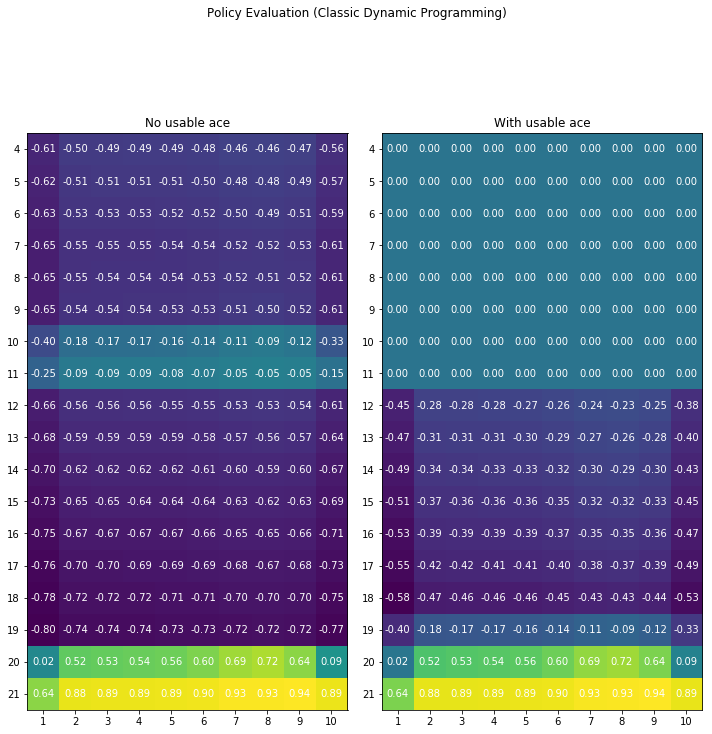

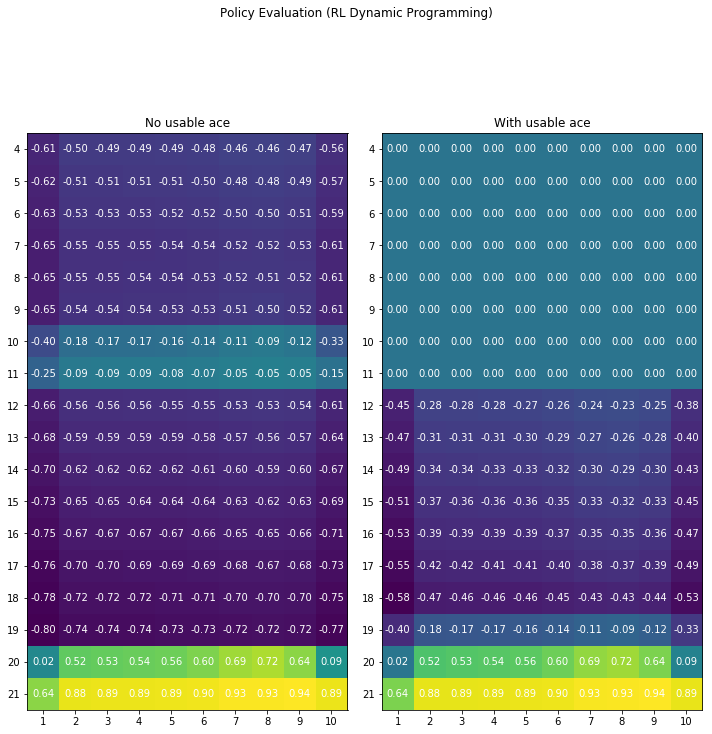

In [8]:
"""
Displaying the State Values V learned by the Dynamic Programming Policy Evaluation
"""


def show_values(state_values: StateValues, title: str = ""):
    player_totals = list(range(4, 21 + 1))
    dealer_cards = list(range(1, 10 + 1))
    no_ace = np.zeros((len(player_totals), len(dealer_cards)))
    with_ace = np.zeros((len(player_totals), len(dealer_cards)))

    for i, player_total in enumerate(player_totals):
        for j, dealer_card in enumerate(dealer_cards):
            state = VisibleState(dealer_card=dealer_card, current_total=player_total, has_usable_ace=False)
            no_ace[i,j] = state_values.get_state_value(state)
            state = VisibleState(dealer_card=dealer_card, current_total=player_total, has_usable_ace=True)
            with_ace[i,j] = state_values.get_state_value(state)

    fig, ax = plt.subplots(figsize=(10, 12), ncols=2)
    ax[0].imshow(no_ace)
    ax[1].imshow(with_ace)
    ax[0].set_title("No usable ace")
    ax[1].set_title("With usable ace")
    if title:
        fig.suptitle(title)
    
    for col, val_map in enumerate([no_ace, with_ace]):
        ax[col].set_yticks(np.arange(len(player_totals)))
        ax[col].set_xticks(np.arange(len(dealer_cards)))
        ax[col].set_yticklabels(player_totals)
        ax[col].set_xticklabels(dealer_cards)
        for i in range(len(player_totals)):
            for j in range(len(dealer_cards)):
                label = "{0:.2f}".format(val_map[i, j])
                ax[col].text(j, i, label, ha="center", va="center", color="w")
    plt.tight_layout()
    plt.show()
    

model = BlackJackExactModel()
policy=initial_policy(epsilon=0.)

state_values_dp = dp_state_values_evaluations(model, policy, reward_discount=1.)
show_values(state_values_dp, title="Policy Evaluation (Classic Dynamic Programming)")

state_values_dp = iterative_dp_state_values_evaluations(model, policy, reward_discount=1., iteration_count=5)
show_values(state_values_dp, title="Policy Evaluation (RL Dynamic Programming)")

Number of iterations: 3


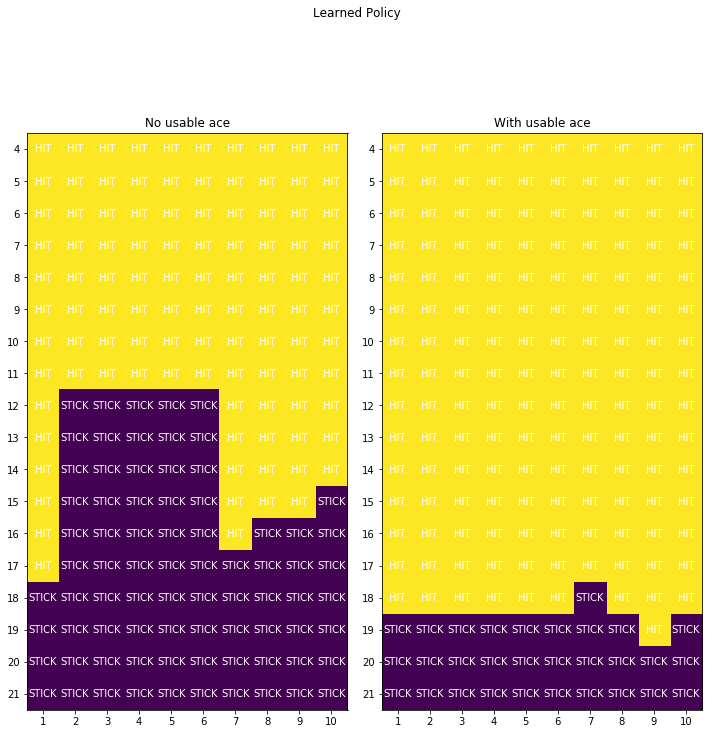

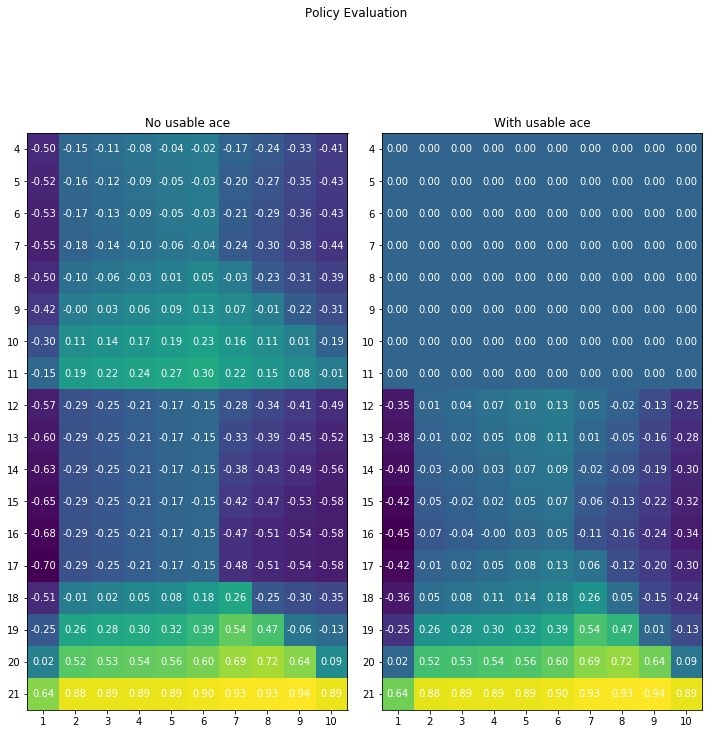

In [9]:
"""
Cycle of policy iteration: policy evaluation and policy improvement
"""


def dp_action_value_evaluation(model: BlackJackModel, policy: Policy, reward_discount: float = 1.):
    state_values = dp_state_values_evaluations(model, policy, reward_discount)
    # state_values = iterative_dp_state_values_evaluations(model, policy, reward_discount, iteration_count=5)
    return ActionValuesFromStateValues(state_values, model)


"""
A nice representation of the policy based on a matrix
"""


def show_policy(policy: Policy, title: str = ""):
    policy.epsilon = 0.0

    player_totals = list(range(4, 21 + 1))
    dealer_cards = list(range(1, 10 + 1))
    no_ace = np.zeros((len(player_totals), len(dealer_cards)))
    with_ace = np.zeros((len(player_totals), len(dealer_cards)))

    for i, player_total in enumerate(player_totals):
        for j, dealer_card in enumerate(dealer_cards):
            state = VisibleState(dealer_card=dealer_card, current_total=player_total, has_usable_ace=False)
            no_ace[i,j] = 1 if policy(state) == Action.HIT else 0
            state = VisibleState(dealer_card=dealer_card, current_total=player_total, has_usable_ace=True)
            with_ace[i,j] = 1 if policy(state) == Action.HIT else 0

    fig, ax = plt.subplots(figsize=(10, 12), ncols=2)
    ax[0].imshow(no_ace)
    ax[1].imshow(with_ace)
    ax[0].set_title("No usable ace")
    ax[1].set_title("With usable ace")
    if title:
        fig.suptitle(title)

    for col, action_map in enumerate([no_ace, with_ace]):
        ax[col].set_yticks(np.arange(len(player_totals)))
        ax[col].set_xticks(np.arange(len(dealer_cards)))
        ax[col].set_yticklabels(player_totals)
        ax[col].set_xticklabels(dealer_cards)

        for i in range(len(player_totals)):
            for j in range(len(dealer_cards)):
                action_label = "HIT" if action_map[i, j] == 1 else "STICK"
                text = ax[col].text(j, i, action_label, ha="center", va="center", color="w")

    plt.tight_layout()
    plt.show()

    
# Note there is not need for epsilon here, since we are not exploring (we do dynamic programming)
# Also, you can try different policies, it should lead to the same result


model = BlackJackExactModel()
# policy=initial_policy(epsilon=0.)
policy = DiscretePolicy(epsilon=0.)

iterations = policy_iteration(model, policy, dp_action_value_evaluation, max_iteration=20)
print("Number of iterations:", iterations)
show_policy(policy, title="Learned Policy")

state_values_dp = dp_state_values_evaluations(model, policy, reward_discount=1.)
show_values(state_values_dp, title="Policy Evaluation")


# TODO - there must be a bug here... the policy is not logical
# Check against http://www.chasingthefrog.com/reelfaces/21basicstrategy.php

In [10]:
"""
Monte Carlo of doing the "Policy Evaluation" following an "on-policy" approach:
- we use the policy to generate new scenarios
- and we keep track of the states and reward to estimate the value

The problem with the approach of Monte Carlo is that:
1) It does not learn from partial episodes
2) It does not learn by bootstrapping (states that are not visited are not very accurate although they could benefit from future states that are accurate)
3) Some tests are really less likely to be visited and will get worse quality data
"""


class MCStateValues(StateValues):
    def __init__(self):
        self.values: Dict[VisibleState, float] = defaultdict(float)
        self.counts: Dict[VisibleState, int] = defaultdict(int)
    
    def add(self, state: VisibleState, score: float):
        self.values[state] += 1 / (self.counts[state] + 1) * (score - self.values[state])
        self.counts[state] += 1
    
    def get_state_value(self, state: VisibleState) -> float:
        return self.values.get(state, 0.)
    
    def get_count(self, state: VisibleState):
        return self.counts.get(state, 0)


def every_visit_monte_carlo_policy_state_evaluation(game: BlackJack, gamma: float, nb_episodes: int, policy: Policy) -> StateValues:
    state_values = MCStateValues()
    
    for _ in range(nb_episodes):
        game.reset()
        
        states, rewards = [], []
        while not game.is_over:
            state = game.get_state()
            action = policy(state)
            reward = game.play(action)
            states.append(state)
            rewards.append(reward)
        
        score = 0.
        for i in reversed(range(len(states))):
            score = rewards[i] + gamma * score
            state_values.add(states[i], score)
    
    return state_values

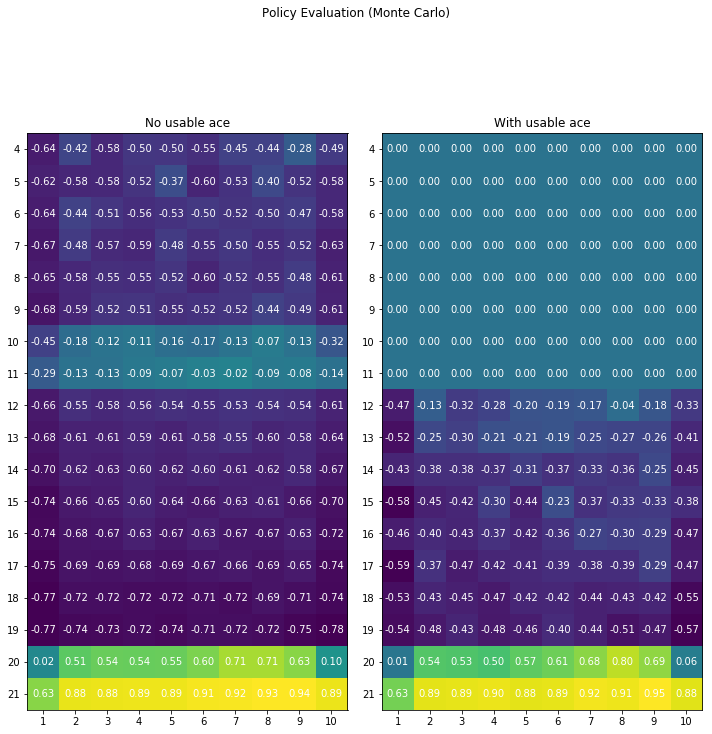

In [11]:
"""
Example of action values, following the policy HIT below 20, and STICK otherwise

PROBLEM HERE:
- the initial states are rather imbalanced... low probability to hit a 4 or 5 value
- so I do not display them here, knowing that the strategy is pretty clear here

BUT IN A REAL GAME, that would be a problem.
"""


state_values_mc = every_visit_monte_carlo_policy_state_evaluation(
    game=BlackJack(),
    gamma=1.,
    nb_episodes=200_000,
    policy=initial_policy())


show_values(state_values_mc, title="Policy Evaluation (Monte Carlo)")

In [12]:
"""
Our previous policy evaluation evaluated the state value V.
In most cases, this is not very useful:
- if we do not know the model, we cannot really use it to take a decision (can't look ahead to next value)
- in such cases, it is either useful to try to evaluate Q instead of V or have a learned model of the probability p(s',r|s,a)

If we search to evaluate Q instead of V, we face the problem of having to try all possibles (s,a):
- either we need to try every possible (s, a) as starting action
- or we need to introduce some randomness in our policy (epsilon greedy policy) else it will only select the same action

If we introduce some randomness, we must realize we do not solve the original problem, but solve a problem of finding the optimal
policy in an environment that does not not really select our chosen action all the time.
"""


class MCActionValues(ActionValues):
    def __init__(self):
        self.values: Dict[VisibleState, Dict[Action, float]] = defaultdict(lambda: defaultdict(float))
        self.counts: Dict[VisibleState, Dict[Action, int]] = defaultdict(lambda: defaultdict(int))
    
    def add(self, state: VisibleState, action: Action, score) -> float:
        prev_value = self.values[state][action]
        self.values[state][action] += 1 / (self.counts[state][action] + 1) * (score - self.values[state][action])
        self.counts[state][action] += 1
        return self.values[state][action] - prev_value
    
    def get_action_value(self, state: VisibleState, action: Action) -> float:
        return self.values[state][action]
    
    def __len__(self):
        return sum(len(actions) for state, actions in self.values.items())


def every_visit_monte_carlo_policy_action_evaluation(
    game: BlackJack,
    gamma: float,
    policy,
    nb_episodes: int = 0,
    stable_below_delta: int = 0,
    evaluation_delta: float = 0.) -> ActionValues:
    
    action_values = MCActionValues()
    count_below_delta = 0
    
    for episode in itertools.count(0):
        if nb_episodes and episode >= nb_episodes:
            break
            
        if stable_below_delta and count_below_delta >= stable_below_delta:
            break
        
        game.reset()
        transitions = []
        rewards = []
        while not game.is_over:
            state = game.get_state()
            action = policy(state)
            reward = game.play(action)
            transitions.append((state, action))
            rewards.append(reward)
        
        score = 0.
        for i in reversed(range(len(transitions))):
            state, action = transitions[i]
            reward = rewards[i]
            score = reward + gamma * score
            diff = action_values.add(state, action, score)
            
            if evaluation_delta:
                if diff > evaluation_delta:
                    count_below_delta = 0
                else:
                    count_below_delta += 1

    return action_values

In [13]:
action_values = every_visit_monte_carlo_policy_action_evaluation(
    game=BlackJack(),
    gamma=1.,
    # nb_episodes=10_000,
    stable_below_delta=500,
    evaluation_delta = 0.1,
    policy=initial_policy(0.1))


print(len(action_values)) # Should be up to 10 (dealer card) * (21-2) (total for player) * 2 (ace or not ace) * 2 (actions) = 760

548


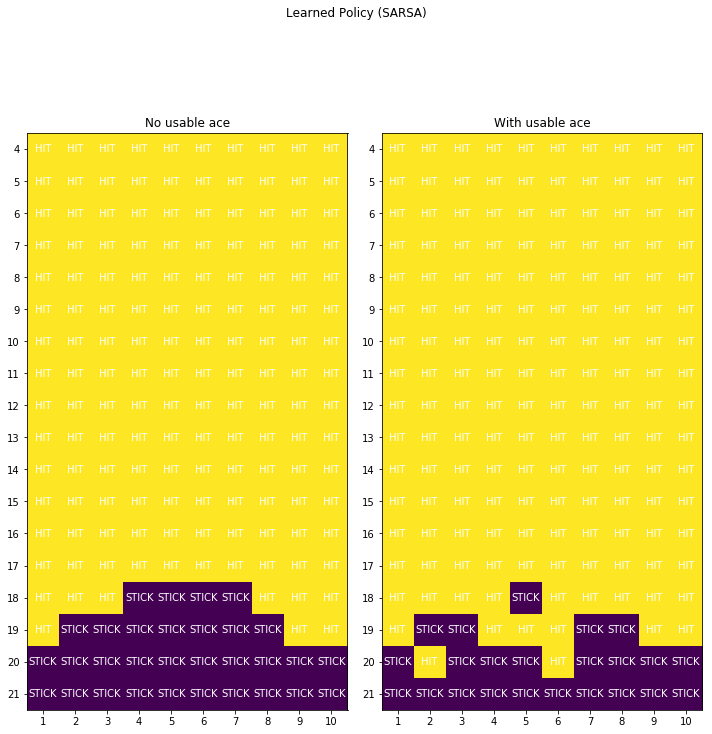

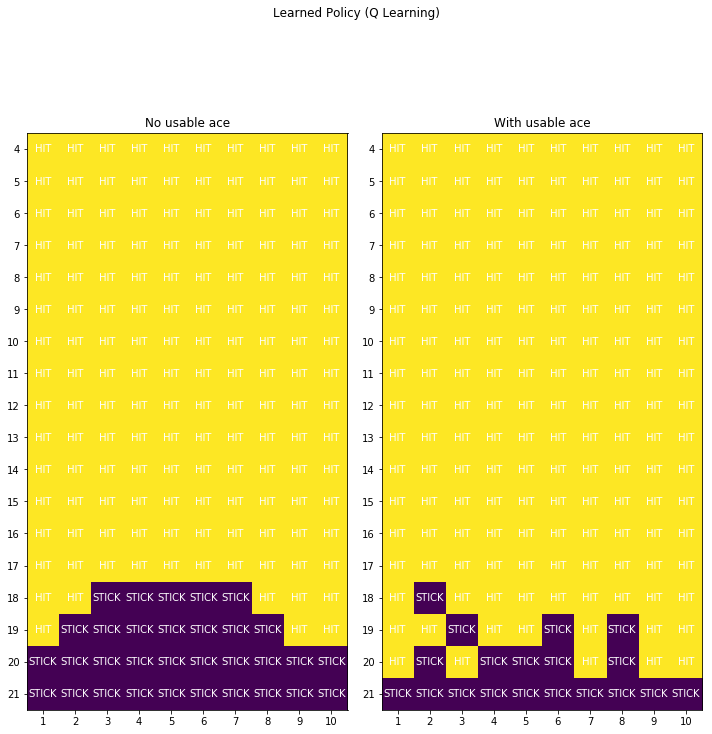

In [15]:
"""
SARSA Algorithm (based on temporal difference learning):
- on-policy: we use the same policy to learn and to sample action to explore the state space
- one-step learning: we immediately bootstrap to learn from the action we just took
"""


class DiscreteActionValues(ActionValues):
    def __init__(self, learning_rate: float = 0.1):
        self.learning_rate = learning_rate
        self.values: Dict[VisibleState, Dict[Action, float]] = defaultdict(lambda: defaultdict(float))
    
    def add(self, state: VisibleState, action: Action, score: float) -> float:
        self.values[state][action] += self.learning_rate * (score - self.values[state][action])
    
    def get_action_value(self, state: VisibleState, action: Action) -> float:
        return self.values[state][action]


class SARSA:
    def __init__(self,
                 default_value: float = 0.,
                 learning_rate: float = 0.1,
                 reward_discount: float = 1.,
                 epsilon: float = 0.1
                ):
        # a big default_value might help favoring exploration at early stages (but biase the results)
        self.q_values = DiscreteActionValues(learning_rate)
        self.reward_discount = reward_discount  # discount factor of future reward taken into account at present time
        self.epsilon = epsilon                  # probability to take a random action
    
    def simulate_episode(self, env) -> Reward:
        total_reward = Reward()
        env.reset()
        while not env.is_done():
            total_reward += self.step(env)
        return total_reward
    
    def step(self, env) -> Reward:
        state = env.get_state()
        action = self._behavior_policy_action(state)
        reward = env.play(action)
        new_state = env.get_state()
        new_action = self._target_policy_action(new_state)
        score = reward + self.reward_discount * self.q_values.get_action_value(new_state, new_action)
        self.q_values.add(state, action, score)
        return reward
    
    def _target_policy_action(self, state):
        return self._behavior_policy_action(state)
    
    def _behavior_policy_action(self, state):
        if self.epsilon > 0. and np.random.random() < self.epsilon:
            return np.random.choice(self.q_values.get_actions(state))
        return self.q_values.get_best_action(state)
    
    def get_policy(self) -> Policy:
        policy = DiscretePolicy(epsilon=self.epsilon)
        policy.improve(self.q_values)
        return policy


class QLearning(SARSA):
    def __init__(self,
                 default_value: float = 0.,
                 learning_rate: float = 0.1,
                 reward_discount: float = 1.,
                 epsilon: float = 0.1
                ):
        super().__init__(default_value=default_value, learning_rate=learning_rate, reward_discount=reward_discount, epsilon=epsilon)
    
    def _target_policy_action(self, state):
        return self.q_values.get_best_action(state)


# Double Q-Learning
    
    
"""
Training loop
"""

    
class RunningAverage:
    def __init__(self):
        self.average = 0.
        self.count = 0
    
    def add(self, value):
        self.average += 1 / (self.count + 1) * (value - self.average)
        self.count += 1
    
    def reset(self):
        self.average = 0.
        self.count = 0
    
    def __call__(self):
        return self.average
    
    
def train_agent(env, agent, nb_episodes: int) -> Policy:
    running_average = RunningAverage()
    temperature_decrease_period = nb_episodes // 21
    temperature_decrease = agent.epsilon / 20
    for episode in range(1, nb_episodes + 1):
        reward = agent.simulate_episode(env)
        running_average.add(reward)
        if episode % temperature_decrease_period == 0:
            # print("Episode", episode, ":", running_average(), " (epsilon " + str(agent.epsilon) + ")")
            agent.epsilon -= temperature_decrease
            running_average.reset()
    return agent.get_policy()

            
policy = train_agent(env=BlackJack(), nb_episodes=250_000, agent=SARSA(default_value=0., learning_rate=0.01, reward_discount=1., epsilon=0.1))
show_policy(policy, title="Learned Policy (SARSA)")

policy = train_agent(env=BlackJack(), nb_episodes=250_000, agent=QLearning(default_value=0., learning_rate=0.01, reward_discount=1., epsilon=0.1))
show_policy(policy, title="Learned Policy (Q Learning)")

In [ ]:
"""
---------------------------------------------------------------------------------------------------------------------

-------------                      STARTING FROM HERE - REFACTORING TO CONTINUE                         -------------

---------------------------------------------------------------------------------------------------------------------
"""

In [14]:
"""
Now playing with a QAgent that:
1. Does not systematically reset its action values (Q values) - the policy evaluation will generally not change everything
2. Is based on value iteration and TEMPORAL DIFFERENCE LEARNING (TODO - verify this)

It converges really fast and produce quality game plans
"""


# TODO - explicit representation of the policy


@dataclass(frozen=True)
class ActionOutcome:
    probability: float
    state: Any
    reward: float
        

class LearnedModel:
    """
    Attempt at modeling the probability (new_state, reward | state, action) of the environment.
    """
    
    def __init__(self):
        self._transitions = defaultdict(Counter)     # map tuple (state, action) to expected target states (with prob)
        self._rewards = defaultdict(float)           # map tuple (state, action, new_state) to reward
        self._total_transitions = Counter()
    
    def add(self, state, action, new_state, reward):
        self._rewards[(state, action, new_state)] = reward
        self._transitions[(state, action)][new_state] += 1
        self._total_transitions[(state, action)] += 1
    
    def outcomes(self, state, action):
        total_transitions = self._total_transitions[(state, action)]
        for new_state, count in self._transitions[(state, action)].items():
            yield ActionOutcome(
                probability=count/total_transitions,
                state=new_state,
                reward=self._rewards[(state, action, new_state)])   


class QValues:
    """
    Map state and action to an expected reward
    """
    
    def __init__(self, default_value: float = 0.):
        self.default_value = default_value     # a big value might help favoring exploration at early stages (but biase the results)
        self.actions = defaultdict(list)       # map state to possible actions at that state
        self.q_values = defaultdict(lambda: defaultdict(float))
    
    def set_actions(self, state, actions):
        self.actions[state] = actions
    
    def get_actions(self, state):
        return self.actions[state]
    
    def get_state_value(self, state):
        if self.actions[state]:
            return self.most_valuable_action(state)[1]
        return self.default_value
    
    def most_valuable_action(self, state):
        best_action = None
        best_value = float('-inf')        
        for action in self.actions[state]:
            value = self.q_values[state].get(action, self.default_value)
            if value > best_value:
                best_action = action
                best_value = value
        return best_action, best_value
    
    def bellman_update(self, state, action, learned_model, blending: float, reward_discount: float):
        expected_reward = 0.
        expected_value = 0.
        for outcome in learned_model.outcomes(state, action):
            expected_reward += outcome.probability * outcome.reward
            expected_value += outcome.probability * self.get_state_value(outcome.state)        
        self.q_values[state][action] = \
            (1 - blending) * self.q_values[state][action] + \
            blending * (expected_reward + reward_discount * expected_value)


class QAgent:
    def __init__(self,
                 reward_discount: float=1.0,
                 temperature: float=1.0):
        self.temperature = temperature          # controls the number of random actions attempted
        self.blending = 0.2                     # discount factor used for Q-values in the bellman update
        self.reward_discount = reward_discount  # discount factor of future reward taken into account at present time
        self.learned_model = LearnedModel()     # approximation of the P(next_state, reward | state, action) of the model
        self.q_values = QValues()               # approximation of the action values (Q values) of the current policy

    def step(self, env) -> float:
        state = env.get_state()
        self.q_values.set_actions(state, env.get_actions())
        action = self.get_action(state)
        reward = env.play(action)
        self.learned_model.add(state, action, env.get_state(), reward)
        self._value_iteration(state, action)
        return reward

    def get_action(self, state):
        """
        Select the next action:
        - with a small chance, take one at random, or
        - pick the one with the best Q-value (expected long term reward)
        """
        if np.random.random() < self.temperature:
            return np.random.choice(self.q_values.get_actions(state))
        action, value = self.q_values.most_valuable_action(state)
        return action

    def temperature_decrease(self, decrease=0.1):
        self.temperature -= decrease
        self.temperature = max(self.temperature, 0.)
    
    def _value_iteration(self, state, action):
        # TODO - keep a record of everything that has been done, and do the update in BULK
        self.q_values.bellman_update(state, action, self.learned_model, blending=self.blending, reward_discount=self.reward_discount)

    
"""
Training
"""


def run_episode(env, agent):
    total_reward = 0.
    env.reset()
    while not env.is_done():
        total_reward += agent.step(env)
    return total_reward


class RunningAverage:
    def __init__(self):
        self.average = 0.
        self.count = 0
    
    def add(self, value):
        self.average += 1 / (self.count + 1) * (value - self.average)
        self.count += 1
    
    def reset(self):
        self.average = 0.
        self.count = 0
    
    def __call__(self):
        return self.average


def train_q_agent(env, agent, nb_episodes: int):
    running_average = RunningAverage()
    temperature_decrease_period = nb_episodes // 20
    for episode in range(1, nb_episodes + 1):
        reward = run_episode(env, agent)
        running_average.add(reward)
        if episode % temperature_decrease_period == 0:
            print("Episode", episode, ":", running_average(), " (temperature " + str(agent.temperature) + ")")
            agent.temperature_decrease(0.04)
            running_average.reset()


game = BlackJack()
agent = QAgent(reward_discount=1.0, temperature=0.7)
train_q_agent(game, agent, nb_episodes=250_000)

Episode 12500 : -0.38096000000000235  (temperature 0.7)
Episode 25000 : -0.3923199999999997  (temperature 0.6599999999999999)
Episode 37500 : -0.38328000000000173  (temperature 0.6199999999999999)
Episode 50000 : -0.3643200000000009  (temperature 0.5799999999999998)
Episode 62500 : -0.37176  (temperature 0.5399999999999998)
Episode 75000 : -0.3870400000000013  (temperature 0.49999999999999983)
Episode 87500 : -0.37055999999999983  (temperature 0.45999999999999985)
Episode 100000 : -0.3703199999999975  (temperature 0.4199999999999999)
Episode 112500 : -0.3567200000000009  (temperature 0.3799999999999999)
Episode 125000 : -0.35112000000000043  (temperature 0.3399999999999999)
Episode 137500 : -0.34311999999999965  (temperature 0.29999999999999993)
Episode 150000 : -0.34824  (temperature 0.25999999999999995)
Episode 162500 : -0.3477599999999999  (temperature 0.21999999999999995)
Episode 175000 : -0.32839999999999914  (temperature 0.17999999999999994)
Episode 187500 : -0.3212800000000008  

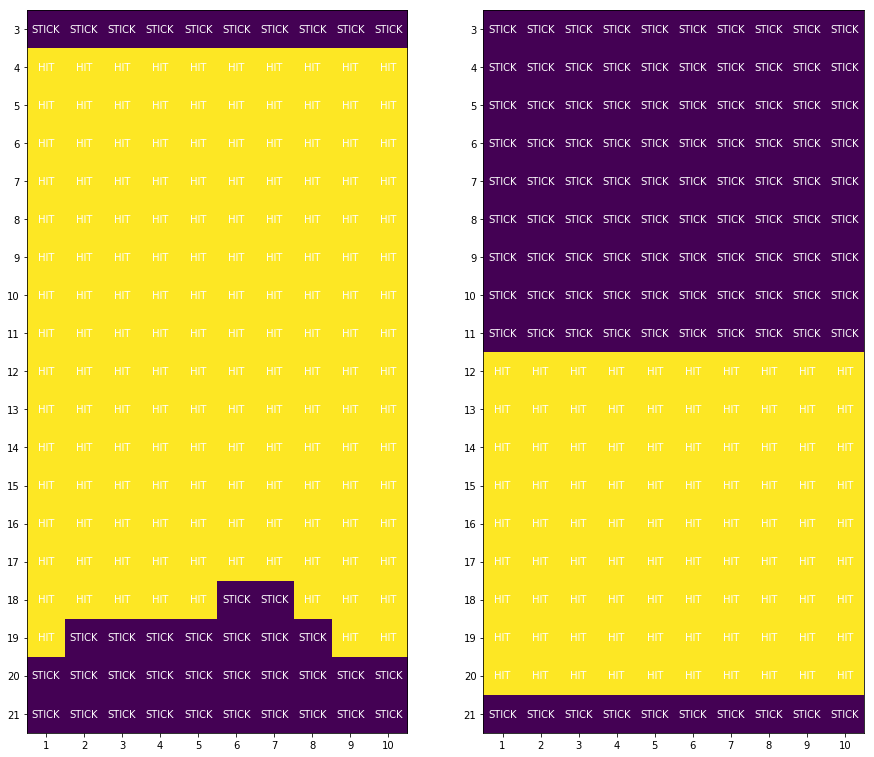

In [15]:
"""
A nice representation of the policy based on a matrix
"""

# TODO - remove the epsilon...
agent.temperature = 0.0

player_totals = list(range(3, 21 + 1))
dealer_cards = list(range(1, 10 + 1))
no_ace = np.zeros((len(player_totals), len(dealer_cards)))
with_ace = np.zeros((len(player_totals), len(dealer_cards)))

for i, player_total in enumerate(player_totals):
    for j, dealer_card in enumerate(dealer_cards):
        action = agent.get_action(VisibleState(dealer_card=dealer_card, current_total=player_total, has_usable_ace=False))
        no_ace[i,j] = 1 if action == Action.HIT else 0
        action = agent.get_action(VisibleState(dealer_card=dealer_card, current_total=player_total, has_usable_ace=True))
        with_ace[i,j] = 1 if action == Action.HIT else 0

fig, ax = plt.subplots(figsize=(15, 30), ncols=2)
ax[0].imshow(no_ace)
ax[1].imshow(with_ace)

for k, heat_map in enumerate([no_ace, with_ace]):
    ax[k].set_yticks(np.arange(len(player_totals)))
    ax[k].set_xticks(np.arange(len(dealer_cards)))
    ax[k].set_yticklabels(player_totals)
    ax[k].set_xticklabels(dealer_cards)
    for i in range(len(player_totals)):
        for j in range(len(dealer_cards)):
            action_label = "HIT" if heat_map[i, j] == 1 else "STICK"
            text = ax[k].text(j, i, action_label, ha="center", va="center", color="w")

plt.show()